## General

This colab notebook installs and uses the [Rapids](https://rapids.ai/) cuML GPU machine learning library to predict nearest image neighbours from the previously generated image embeddings.

The Rapids cuML library functions similarly to the sci-kit learn library and runs on GPU processing.

It is especially advantageous for this project as the cuML.NearestNeighbors algorithm is significantly faster than sklearn.NearestNeighbors for predicting nearest neighbours with a large feature size of 1792.

In [1]:
# Check for P4, P100, T4, or V100, else factory reset runtime
!nvidia-smi

Fri Apr 23 01:25:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 213 (delta 22), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (213/213), 64.29 KiB | 16.07 MiB/s, done.
Resolving deltas: 100% (84/84), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), global

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

from PIL import Image
from cuml.neighbors import NearestNeighbors as cuml_NN

In [4]:
# Load train data
train = pd.DataFrame(np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train.npy', allow_pickle=True),
                     columns=['posting_id', 'image', 'image_phash', 'title', 'label_group', 'matches', 'image_duplicates'])

## Predict Nearest Neighbours

In [5]:
# Create function to make predictions of closest neighbours based on embeddings and distance cutoff
def predict(df, embeddings, n_neighbours, threshold, metric = 'euclidean'):
  preds = []

  # Generate distances and indices of each data point using cuML NearestNeighbors
  NN_model = cuml_NN(n_neighbors = n_neighbours, metric = metric)
  NN_model.fit(embeddings)
  distances, indices = NN_model.kneighbors(embeddings)

  # Append posting_ids of indices that are within distance threshold
  for i in range(embeddings.shape[0]):
    idx = indices[i][np.where(distances[i] <= threshold)]
    posting_ids = df['posting_id'].iloc[idx].values
    preds.append(posting_ids)
  
  return preds

In [6]:
# Create function to generate F1 score for each row of predictions and actual matches
def scores(matches, preds):
  result = []
  for i in range(len(matches)):
    n = len(np.intersect1d(matches[i], preds[i]))
    score = 2*n / (len(matches[i]) + len(preds[i]))
    result.append(score)
  return result

In [7]:
# Create function to grid search over various distance thresholds
def distance_search(df, embeddings, n_neighbours, thresholds = list(range(5,16)), metric = 'euclidean'):
  matches = list(df['matches'].to_numpy())
  for t in thresholds:
    predictions_t = predict(df, embeddings, n_neighbours, t, metric)
    f1_score_t = scores(matches, predictions_t)
    print(f'At threshold {t}, average F1 score is {np.mean(f1_score_t)}')

In [8]:
# Obtain actual matches from dataframe
matches = list(train['matches'].to_numpy())

In [9]:
# Compute baseline F1 score using image duplicates
np.mean(scores(matches, list(train['image_duplicates'].to_numpy())))

0.5530933399168149

### Default EfficientNetB4

In [10]:
# Load default EfficientNetB4 embeddings
train_image_embeddings = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings.npy')

In [11]:
# Grid search over various Euclidean distance thresholds
distance_search(train, train_image_embeddings, 51, list(range(10)))

At threshold 0, average F1 score is 0.2463276751234342
At threshold 1, average F1 score is 0.5392354880834166
At threshold 2, average F1 score is 0.5807158556609637
At threshold 3, average F1 score is 0.6127473719893204
At threshold 4, average F1 score is 0.6317418847518397
At threshold 5, average F1 score is 0.633995712957992
At threshold 6, average F1 score is 0.5995601512454218
At threshold 7, average F1 score is 0.5233526066941516
At threshold 8, average F1 score is 0.4332621808687683
At threshold 9, average F1 score is 0.3361809878394782


In [12]:
# Grid search over various cosine distance thresholds
distance_search(train, train_image_embeddings, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.2426471474755975
At threshold 0.03333333333333333, average F1 score is 0.5990869694065848
At threshold 0.06666666666666667, average F1 score is 0.6261334572306481
At threshold 0.1, average F1 score is 0.6429660785666392
At threshold 0.13333333333333333, average F1 score is 0.6521890796009098
At threshold 0.16666666666666666, average F1 score is 0.6523205215472779
At threshold 0.2, average F1 score is 0.6383687722852047
At threshold 0.23333333333333334, average F1 score is 0.6083016981352262
At threshold 0.26666666666666666, average F1 score is 0.5657250833130404
At threshold 0.3, average F1 score is 0.5159032141511779


### Model 1

In [13]:
# Load model 1 embeddings
train_image_embeddings_1 = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_1.npy')

In [14]:
# Grid search over various Euclidean distance thresholds
distance_search(train, train_image_embeddings_1, 51, list(range(5,15)))

At threshold 5, average F1 score is 0.5941225042242271
At threshold 6, average F1 score is 0.6079718191665884
At threshold 7, average F1 score is 0.619501992351154
At threshold 8, average F1 score is 0.6301131990605553
At threshold 9, average F1 score is 0.6410598315185437
At threshold 10, average F1 score is 0.649831134644556
At threshold 11, average F1 score is 0.6557030212884035
At threshold 12, average F1 score is 0.6552506733579039
At threshold 13, average F1 score is 0.6448660090873308
At threshold 14, average F1 score is 0.619572168547457


In [ ]:
# Grid search over various cosine distance thresholds
distance_search(train, train_image_embeddings_1, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.23610593145959727
At threshold 0.03333333333333333, average F1 score is 0.6044676237950254
At threshold 0.06666666666666667, average F1 score is 0.6308349559838081
At threshold 0.1, average F1 score is 0.6507807148368541
At threshold 0.13333333333333333, average F1 score is 0.6648127924236068
At threshold 0.16666666666666666, average F1 score is 0.6731890657831503
At threshold 0.2, average F1 score is 0.6711768013324797
At threshold 0.23333333333333334, average F1 score is 0.6491701322977815
At threshold 0.26666666666666666, average F1 score is 0.6017797592651812
At threshold 0.3, average F1 score is 0.5293593834739676


### Model 2

In [15]:
# Load model 2 embeddings
train_image_embeddings_2 = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_2.npy')

In [16]:
# Grid search over various Euclidean distance thresholds
distance_search(train, train_image_embeddings_2, 51, list(range(5,15)))

At threshold 5, average F1 score is 0.587341976607458
At threshold 6, average F1 score is 0.6023509075017851
At threshold 7, average F1 score is 0.613702535120207
At threshold 8, average F1 score is 0.6243416252151763
At threshold 9, average F1 score is 0.6335222218526387
At threshold 10, average F1 score is 0.6431766128333589
At threshold 11, average F1 score is 0.6501231197388796
At threshold 12, average F1 score is 0.6542731512028666
At threshold 13, average F1 score is 0.6544311377668058
At threshold 14, average F1 score is 0.6455879699495974


In [ ]:
# Grid search over various cosine distance thresholds
distance_search(train, train_image_embeddings_2, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.227350623642897
At threshold 0.03333333333333333, average F1 score is 0.6023202159223816
At threshold 0.06666666666666667, average F1 score is 0.6295300029730729
At threshold 0.1, average F1 score is 0.6487750401932953
At threshold 0.13333333333333333, average F1 score is 0.6652651629087623
At threshold 0.16666666666666666, average F1 score is 0.6779649189091833
At threshold 0.2, average F1 score is 0.6850139409886379
At threshold 0.23333333333333334, average F1 score is 0.679665624317359
At threshold 0.26666666666666666, average F1 score is 0.6559161235711686
At threshold 0.3, average F1 score is 0.6049902339895529


### Model 3

In [17]:
# Load model 3 embeddings
train_image_embeddings_3 = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_3.npy')

In [18]:
# Grid search over various Euclidean distance thresholds
distance_search(train, train_image_embeddings_3, 51, list(range(5,15)))

At threshold 5, average F1 score is 0.5998092090294797
At threshold 6, average F1 score is 0.6138849388750846
At threshold 7, average F1 score is 0.6259867630773203
At threshold 8, average F1 score is 0.6375618985094813
At threshold 9, average F1 score is 0.648963918438606
At threshold 10, average F1 score is 0.6589601721193894
At threshold 11, average F1 score is 0.6649623525929903
At threshold 12, average F1 score is 0.6638924233182261
At threshold 13, average F1 score is 0.6471692113526513
At threshold 14, average F1 score is 0.6100696079911209


In [ ]:
# Grid search over various cosine distance thresholds
distance_search(train, train_image_embeddings_3, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.23607566931335822
At threshold 0.03333333333333333, average F1 score is 0.6026723975635161
At threshold 0.06666666666666667, average F1 score is 0.6290023326254182
At threshold 0.1, average F1 score is 0.6488889402961491
At threshold 0.13333333333333333, average F1 score is 0.6641122730039146
At threshold 0.16666666666666666, average F1 score is 0.6755057527844613
At threshold 0.2, average F1 score is 0.6806974507472847
At threshold 0.23333333333333334, average F1 score is 0.6736462396285687
At threshold 0.26666666666666666, average F1 score is 0.6473340832869516
At threshold 0.3, average F1 score is 0.5970591792372085


### Model 4

In [19]:
# Load model 4 embeddings
train_image_embeddings_4 = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_4.npy')

In [20]:
# Grid search over various Euclidean distance thresholds
distance_search(train, train_image_embeddings_4, 51, list(range(5,15)))

At threshold 5, average F1 score is 0.610986527653133
At threshold 6, average F1 score is 0.6210639533170835
At threshold 7, average F1 score is 0.6302890236320616
At threshold 8, average F1 score is 0.6372813452700948
At threshold 9, average F1 score is 0.6350986976468095
At threshold 10, average F1 score is 0.6003224705095506
At threshold 11, average F1 score is 0.48820451239327595
At threshold 12, average F1 score is 0.32801283274775495
At threshold 13, average F1 score is 0.20854656782028663
At threshold 14, average F1 score is 0.1496208467281139


In [ ]:
# Grid search over various cosine distance thresholds
distance_search(train, train_image_embeddings_4, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.23446895258474604
At threshold 0.03333333333333333, average F1 score is 0.597875601995675
At threshold 0.06666666666666667, average F1 score is 0.6151106705457392
At threshold 0.1, average F1 score is 0.6270377280169716
At threshold 0.13333333333333333, average F1 score is 0.6343389664303796
At threshold 0.16666666666666666, average F1 score is 0.634459791202627
At threshold 0.2, average F1 score is 0.6263243909487832
At threshold 0.23333333333333334, average F1 score is 0.6042690712160018
At threshold 0.26666666666666666, average F1 score is 0.5637407437997729
At threshold 0.3, average F1 score is 0.49501967560464516


### Model 5

In [21]:
# Load model 5 embeddings
train_image_embeddings_5 = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_5.npy')

In [22]:
# Grid search over various Euclidean distance thresholds
distance_search(train, train_image_embeddings_5, 51, list(range(5,15)))

At threshold 5, average F1 score is 0.6104644568819239
At threshold 6, average F1 score is 0.6203118273663882
At threshold 7, average F1 score is 0.6285180026617477
At threshold 8, average F1 score is 0.6323305475227052
At threshold 9, average F1 score is 0.6162009342518329
At threshold 10, average F1 score is 0.5355651296945381
At threshold 11, average F1 score is 0.3706208113245687
At threshold 12, average F1 score is 0.21654440811159792
At threshold 13, average F1 score is 0.14105766912806772
At threshold 14, average F1 score is 0.11629727188183292


In [ ]:
# Grid search over various cosine distance thresholds
distance_search(train, train_image_embeddings_5, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.23797405696177504
At threshold 0.03333333333333333, average F1 score is 0.598796824456833
At threshold 0.06666666666666667, average F1 score is 0.6157274847522689
At threshold 0.1, average F1 score is 0.625795276709144
At threshold 0.13333333333333333, average F1 score is 0.6289831451447154
At threshold 0.16666666666666666, average F1 score is 0.6179909079619373
At threshold 0.2, average F1 score is 0.582538651376764
At threshold 0.23333333333333334, average F1 score is 0.5122167561358594
At threshold 0.26666666666666666, average F1 score is 0.4108731895580266
At threshold 0.3, average F1 score is 0.2967073792523375


### Model 6

In [23]:
# Load model 6 embeddings
train_image_embeddings_6 = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_6.npy')

In [28]:
# Grid search over various Euclidean distance thresholds
distance_search(train, train_image_embeddings_6, 51, list(range(12,22)))

At threshold 12, average F1 score is 0.643932691998881
At threshold 13, average F1 score is 0.6523718819953627
At threshold 14, average F1 score is 0.660882161635407
At threshold 15, average F1 score is 0.6683708706951851
At threshold 16, average F1 score is 0.6757252745904159
At threshold 17, average F1 score is 0.6811309466121349
At threshold 18, average F1 score is 0.6841996757176797
At threshold 19, average F1 score is 0.6815386112328264
At threshold 20, average F1 score is 0.6695619746141341
At threshold 21, average F1 score is 0.6449528951031458


In [29]:
# Grid search over various cosine distance thresholds
distance_search(train, train_image_embeddings_6, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.22911475105667845
At threshold 0.03333333333333333, average F1 score is 0.6128002728869415
At threshold 0.06666666666666667, average F1 score is 0.6426937692434073
At threshold 0.1, average F1 score is 0.6643420207973925
At threshold 0.13333333333333333, average F1 score is 0.6814414705405667
At threshold 0.16666666666666666, average F1 score is 0.6955051035188613
At threshold 0.2, average F1 score is 0.7012727335549982
At threshold 0.23333333333333334, average F1 score is 0.6945738358717319
At threshold 0.26666666666666666, average F1 score is 0.6641591428245964
At threshold 0.3, average F1 score is 0.6044738135341587


### Model 7

In [30]:
# Load model 7 embeddings
train_image_embeddings_7 = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_7.npy')

In [31]:
# Grid search over various Euclidean distance thresholds
distance_search(train, train_image_embeddings_7, 51, list(range(5,15)))

At threshold 5, average F1 score is 0.5970857240817716
At threshold 6, average F1 score is 0.6112722772717067
At threshold 7, average F1 score is 0.6230938143388669
At threshold 8, average F1 score is 0.6346517480275065
At threshold 9, average F1 score is 0.6459718643599265
At threshold 10, average F1 score is 0.6560766625676053
At threshold 11, average F1 score is 0.6621797016509439
At threshold 12, average F1 score is 0.6591041055138358
At threshold 13, average F1 score is 0.6375542987305152
At threshold 14, average F1 score is 0.5940671250522944


In [32]:
# Grid search over various cosine distance thresholds
distance_search(train, train_image_embeddings_7, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.23572704640382697
At threshold 0.03333333333333333, average F1 score is 0.5969989758665638
At threshold 0.06666666666666667, average F1 score is 0.6228201421957802
At threshold 0.1, average F1 score is 0.6414945910862927
At threshold 0.13333333333333333, average F1 score is 0.6559192970270207
At threshold 0.16666666666666666, average F1 score is 0.6685245139070315
At threshold 0.2, average F1 score is 0.6763308334905158
At threshold 0.23333333333333334, average F1 score is 0.6791278780638302
At threshold 0.26666666666666666, average F1 score is 0.6700875499853358
At threshold 0.3, average F1 score is 0.6424039511851241


### Model 8

In [33]:
# Load model 8 embeddings
train_image_embeddings_8 = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_8.npy')

In [36]:
# Grid search over various Euclidean distance thresholds
distance_search(train, train_image_embeddings_8, 51, list(range(12,22)))

At threshold 12, average F1 score is 0.6282461073511596
At threshold 13, average F1 score is 0.6351760066221015
At threshold 14, average F1 score is 0.6429984353114153
At threshold 15, average F1 score is 0.6502664447432734
At threshold 16, average F1 score is 0.6569705269597749
At threshold 17, average F1 score is 0.6638552534617121
At threshold 18, average F1 score is 0.669654291843757
At threshold 19, average F1 score is 0.6735934114410781
At threshold 20, average F1 score is 0.6746776462828121
At threshold 21, average F1 score is 0.6715395376378503


In [35]:
# Grid search over various cosine distance thresholds
distance_search(train, train_image_embeddings_8, 51, np.linspace(0,0.3,10), 'cosine')

At threshold 0.0, average F1 score is 0.21364973017332778
At threshold 0.03333333333333333, average F1 score is 0.6044561238211485
At threshold 0.06666666666666667, average F1 score is 0.6333184885442007
At threshold 0.1, average F1 score is 0.6544590773393532
At threshold 0.13333333333333333, average F1 score is 0.6725480093832961
At threshold 0.16666666666666666, average F1 score is 0.688768213114003
At threshold 0.2, average F1 score is 0.7022755594216474
At threshold 0.23333333333333334, average F1 score is 0.7108554084244094
At threshold 0.26666666666666666, average F1 score is 0.7087232662997868
At threshold 0.3, average F1 score is 0.6881814250716142


### Save Best Results

In [37]:
# Best results come from models 6 and 8
predictions_6e = predict(train, train_image_embeddings_6, 51, 18)
f1_scores_6e = scores(matches, predictions_6e)

predictions_6c = predict(train, train_image_embeddings_6, 51, 0.2, 'cosine')
f1_scores_6c = scores(matches, predictions_6c)

predictions_8e = predict(train, train_image_embeddings_8, 51, 20)
f1_scores_8e = scores(matches, predictions_8e)

predictions_8c = predict(train, train_image_embeddings_8, 51, 0.233333, 'cosine')
f1_scores_8c = scores(matches, predictions_8c)

In [38]:
# Append best results to train dataframe
train['predictions_6e'] = predictions_6e
train['f1_scores_6e'] = f1_scores_6e
train['predictions_6c'] = predictions_6c
train['f1_scores_6c'] = f1_scores_6c
train['predictions_8e'] = predictions_8e
train['f1_scores_8e'] = f1_scores_8e
train['predictions_8c'] = predictions_8c
train['f1_scores_8c'] = f1_scores_8c

In [40]:
train.columns

Index(['posting_id', 'image', 'image_phash', 'title', 'label_group', 'matches',
       'image_duplicates', 'predictions_6e', 'f1_scores_6e', 'predictions_6c',
       'f1_scores_6c', 'predictions_8e', 'f1_scores_8e', 'predictions_8c',
       'f1_scores_8c'],
      dtype='object')

In [41]:
# Save predictions and F1 scores
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_predictions.npy', train.to_numpy())

In [42]:
# Save cosine distances and indices of best image model 8c
NN_model = cuml_NN(n_neighbors = 51, metric = 'cosine')
NN_model.fit(train_image_embeddings_8)
distances, indices = NN_model.kneighbors(train_image_embeddings_8)

In [43]:
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/best_image_distances.npy', distances)
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/best_image_indices.npy', indices)

## Scores and Results

A summary of all image models and their best F1 scores is shown below.

|No |Model|Euclidean Threshold|Best F1 Score|Cosine Threshold|Best F1 Score|
|---|-----|------------------|----------------|------------------|----------------|
|0  |Default EfficientNetB4|5|0.634|0.167|0.652|
|1  |B4 with top_conv retrained (batch:32, epochs:3)|11|0.656|0.167|0.673|
|2  |B4 with block7b_project_conv, top_conv retrained (batch:32, epochs:3)|13|0.654|0.2|0.685|
|3  |B4 with block7b, top_conv retrained (batch:32, epochs:3)|11|0.665|0.2|0.681|
|4  |Entire B4 retrained (batch:8, epochs:10)|8|0.637|0.167|0.634|
|5  |Entire B4 retrained (batch:8, epochs:5)|8|0.632|0.133|0.629|
|6  |B4 with block7a, block7b, top_conv retrained (batch:32, epochs:3)|18|0.684|0.2|0.701|
|7  |B4 with block7b, top_conv retrained (batch:32, epochs:6)|11|0.662|0.233|0.679|
|8  |B4 with block7a, block7b, top_conv retrained (batch:32, epochs:6)|20|0.675|0.233|0.710|

### Distribution of F1 scores

In [27]:
# Imports (CPU only)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

In [2]:
# Load model 8 embeddings
train_image_embeddings_8 = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_8.npy')

# Load distances and indices of best model 8c
distances = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/best_image_distances.npy')
indices = np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/best_image_indices.npy')

In [3]:
# Load image predictions and F1 scores
train = pd.DataFrame(np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_predictions.npy', allow_pickle=True),
                     columns=['posting_id', 'image', 'image_phash', 'title', 'label_group', 'matches', 'image_duplicates',
                              'predictions_6e', 'f1_scores_6e', 'predictions_6c', 'f1_scores_6c',
                              'predictions_8e', 'f1_scores_8e', 'predictions_8c', 'f1_scores_8c'])

In [4]:
# Check first 5 rows
train.head()

posting_id  ... f1_scores_8c
0   train_129225211  ...     0.666667
1  train_3386243561  ...          0.5
2  train_2288590299  ...     0.666667
3  train_2406599165  ...     0.333333
4  train_3369186413  ...            1

[5 rows x 15 columns]

In [5]:
# Models to explore
models = ['6e', '6c', '8e', '8c']

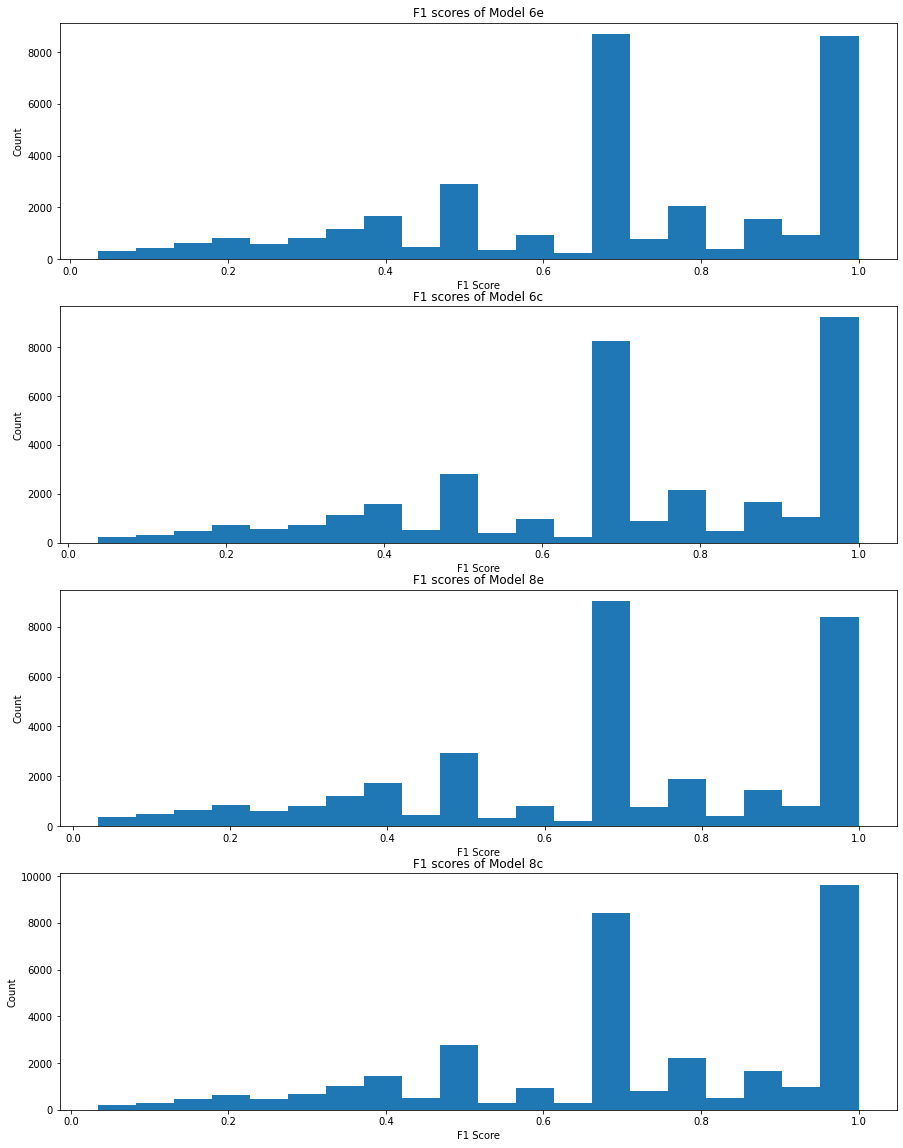

In [6]:
# Check distribution of F1 scores
plt.figure(figsize=(15,5*len(models)))

for i in range(len(models)):
  plt.subplot(len(models), 1, i + 1)
  plt.hist(train[f'f1_scores_{models[i]}'], bins=20)
  plt.ylabel('Count')
  plt.xlabel('F1 Score')
  plt.title(f'F1 scores of Model {models[i]}')

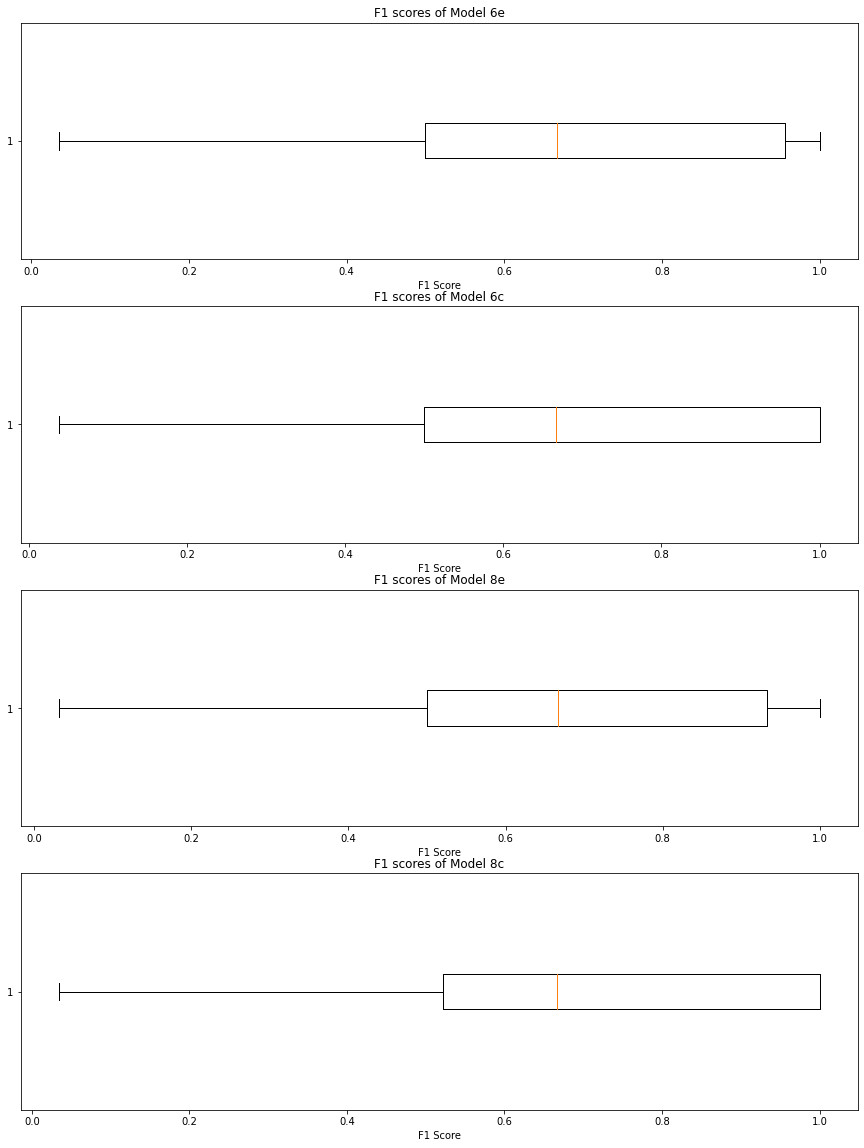

In [7]:
# Check distribution of F1 scores
plt.figure(figsize=(15,5*len(models)))

for i in range(len(models)):
  plt.subplot(len(models), 1, i + 1)
  plt.boxplot(train[f'f1_scores_{models[i]}'], vert=False)
  plt.xlabel('F1 Score')
  plt.title(f'F1 scores of Model {models[i]}');

In [8]:
# Check F1 score value counts
for i in range(len(models)):
  print(f'Most frequent F1 score of model {models[i]}')
  print(train[f'f1_scores_{models[i]}'].value_counts().head(10))
  print('')

Most frequent F1 score of model 6e
0.666667    8560
1.000000    8420
0.500000    2805
0.800000    1817
0.400000    1525
0.333333     902
0.857143     831
0.285714     627
0.571429     568
0.888889     503
Name: f1_scores_6e, dtype: int64

Most frequent F1 score of model 6c
1.000000    8884
0.666667    8071
0.500000    2670
0.800000    1854
0.400000    1439
0.333333     881
0.857143     876
0.571429     618
0.285714     570
0.750000     492
Name: f1_scores_6c, dtype: int64

Most frequent F1 score of model 8e
0.666667    8878
1.000000    8142
0.500000    2800
0.800000    1685
0.400000    1575
0.333333     952
0.857143     817
0.285714     629
0.571429     498
0.750000     448
Name: f1_scores_8e, dtype: int64

Most frequent F1 score of model 8c
1.000000    9298
0.666667    8275
0.500000    2688
0.800000    1871
0.400000    1379
0.857143     862
0.333333     861
0.571429     629
0.285714     548
0.888889     491
Name: f1_scores_8c, dtype: int64



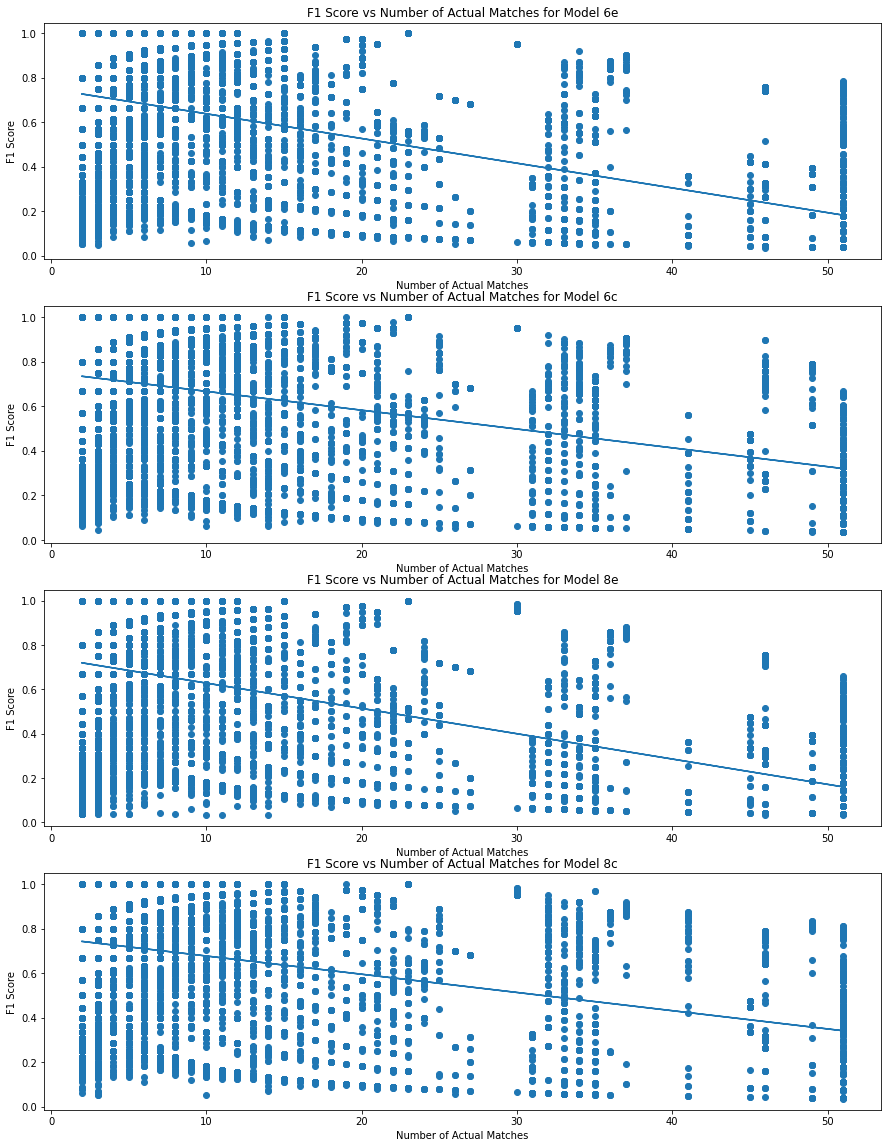

In [9]:
# Check F1 scores by number of matches
plt.figure(figsize = (15,5*len(models)))
x = [(len(match)) for match in train['matches']]

for i in range(len(models)):
  y = train[f'f1_scores_{models[i]}'].astype('float64')
  plt.subplot(len(models), 1, i + 1)
  plt.scatter(x, y)
  m, b = np.polyfit(x, y, 1)
  plt.plot(x, [m*i for i in x] + b)
  plt.xlabel('Number of Actual Matches')
  plt.ylabel('F1 Score')
  plt.title(f'F1 Score vs Number of Actual Matches for Model {models[i]}');

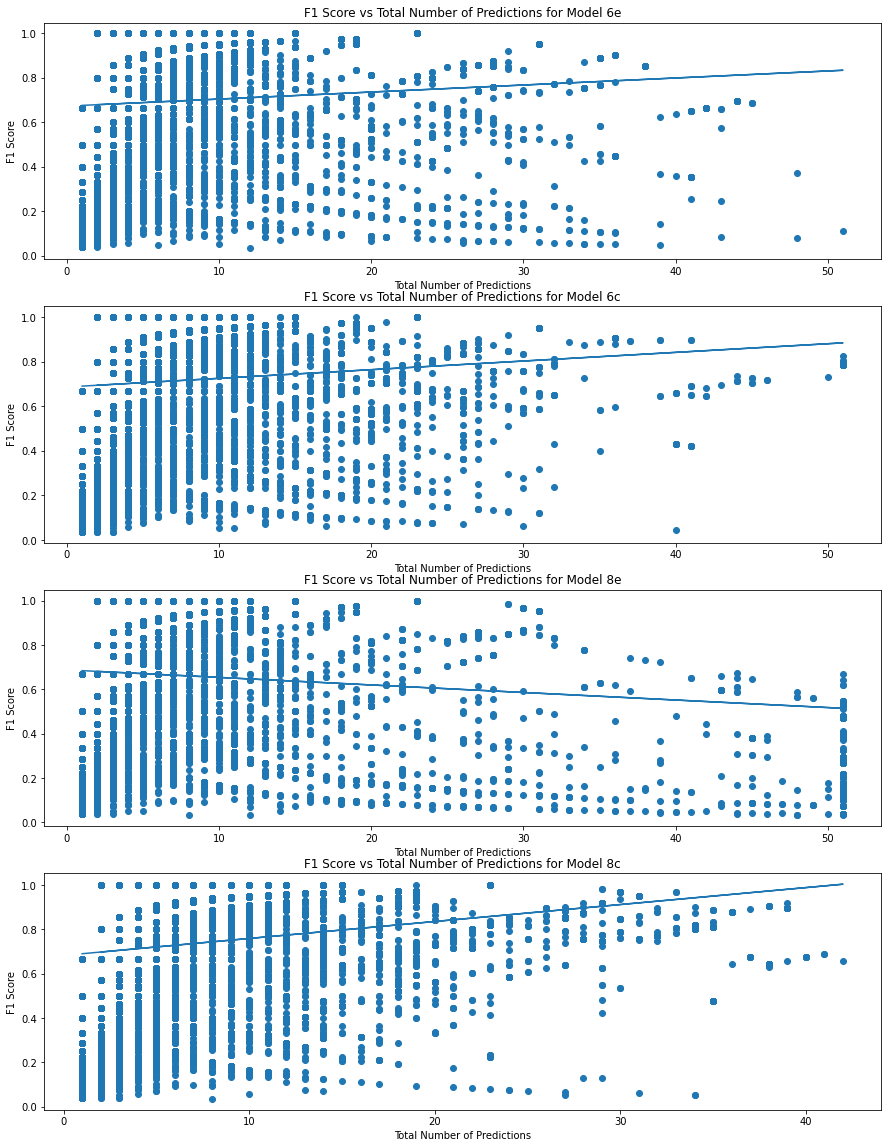

In [10]:
# Check F1 scores by number of predictions
plt.figure(figsize = (15,5*len(models)))

for i in range(len(models)):
  x = [len(pred) for pred in train[f'predictions_{models[i]}']]
  y = train[f'f1_scores_{models[i]}'].astype('float64')
  plt.subplot(len(models), 1, i + 1)
  plt.scatter(x, y)
  m, b = np.polyfit(x, y, 1)
  plt.plot(x, [m*i for i in x] + b)
  plt.xlabel('Total Number of Predictions')
  plt.ylabel('F1 Score')
  plt.title(f'F1 Score vs Total Number of Predictions for Model {models[i]}');

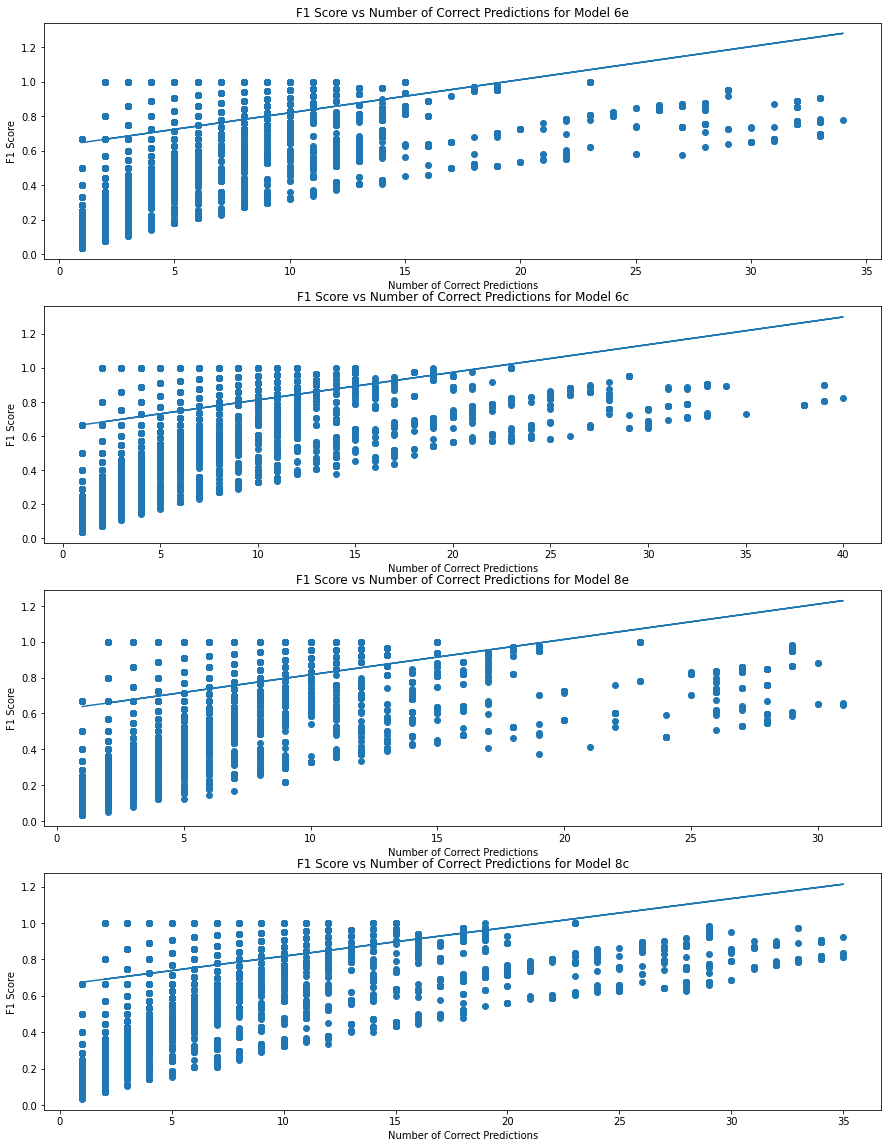

In [11]:
# Check F1 scores by number of correct predictions
plt.figure(figsize = (15,5*len(models)))

for i in range(len(models)):
  x = []
  for j in range(len(train['matches'])):
    x.append(len(np.intersect1d(train['matches'][j], train[f'predictions_{models[i]}'][j])))
  y = train[f'f1_scores_{models[i]}'].astype('float64')
  plt.subplot(len(models), 1, i + 1)
  plt.scatter(x, y)
  m, b = np.polyfit(x, y, 1)
  plt.plot(x, [m*i for i in x] + b)
  plt.xlabel('Number of Correct Predictions')
  plt.ylabel('F1 Score')
  plt.title(f'F1 Score vs Number of Correct Predictions for Model {models[i]}');

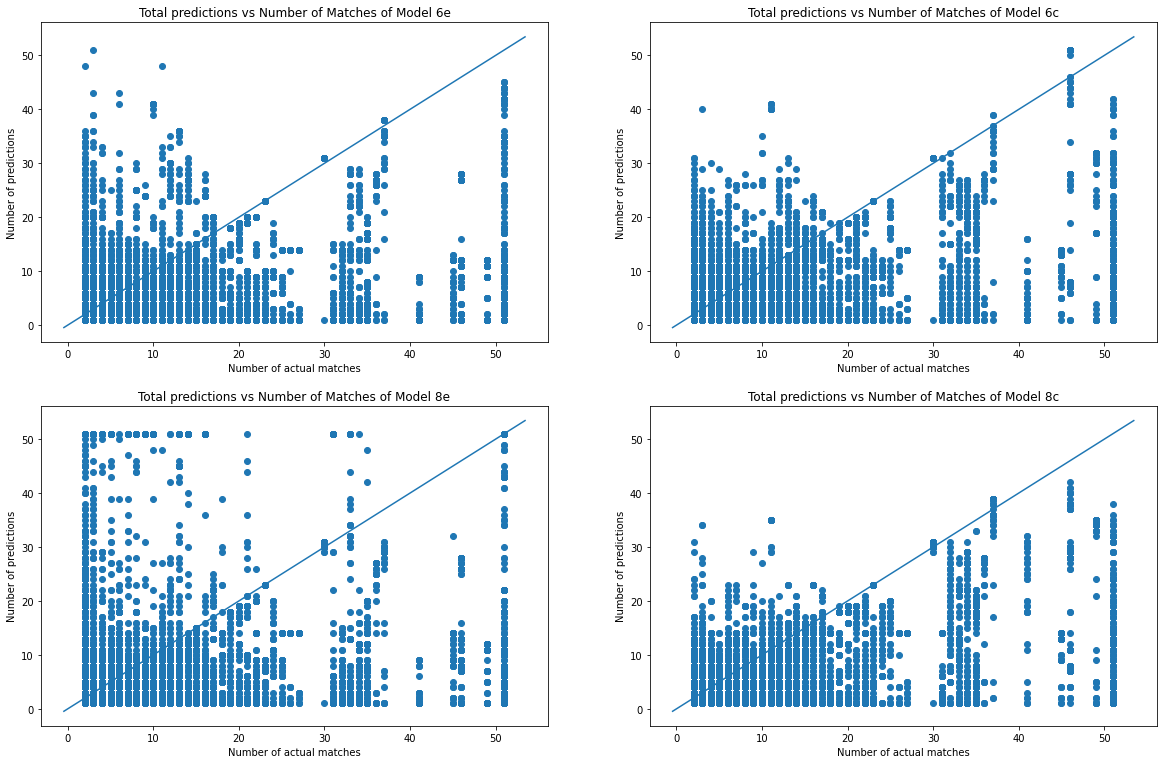

In [13]:
# Check number of predictions vs number of matches
plt.figure(figsize=(20,20))
x = [(len(match)) for match in train['matches']]

for i in range(len(models)):
  y = [len(pred) for pred in train[f'predictions_{models[i]}']]
  plt.subplot(len(models) // 2 + 1, 2, i+1)
  plt.scatter(x, y)
  xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints)
  plt.xlabel('Number of actual matches')
  plt.ylabel('Number of predictions')
  plt.title(f'Total predictions vs Number of Matches of Model {models[i]}');

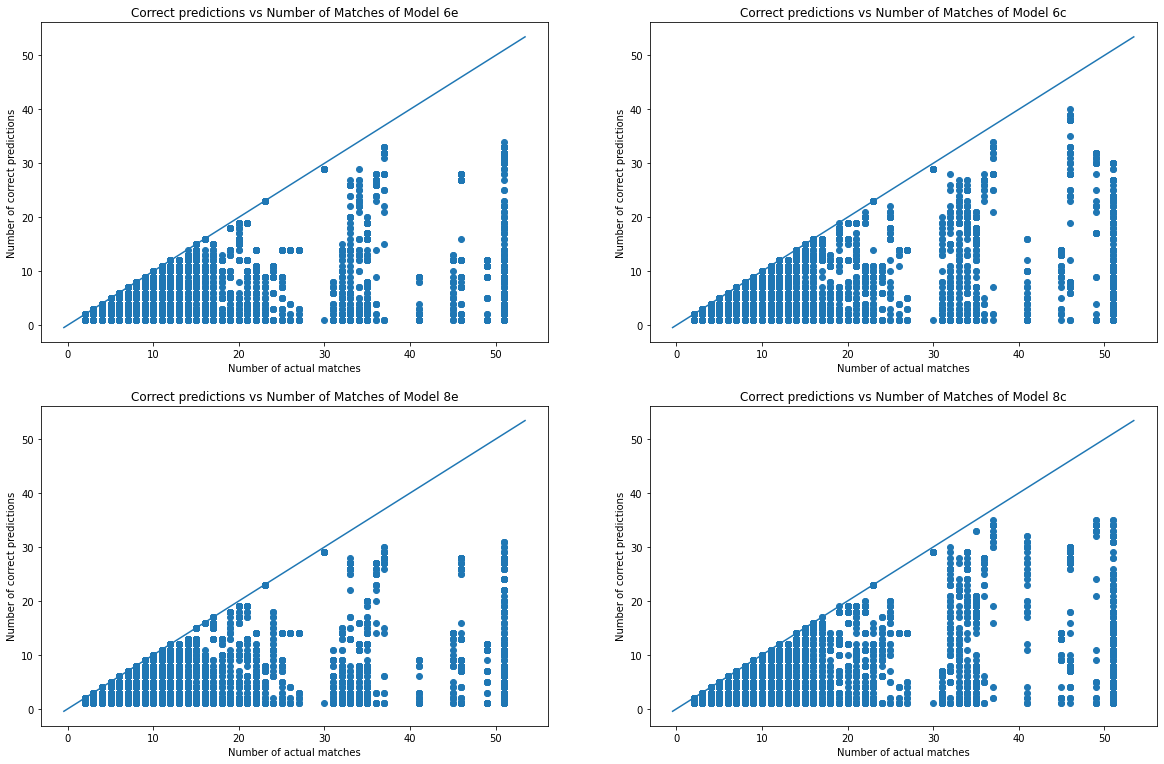

In [14]:
# Check number of correct predictions vs number of matches
plt.figure(figsize=(20,20))
x = [(len(match)) for match in train['matches']]

for i in range(len(models)):
  y = []
  for j in range(len(train['matches'])):
    y.append(len(np.intersect1d(train['matches'][j], train[f'predictions_{models[i]}'][j])))
  plt.subplot(len(models) // 2 + 1, 2, i+1)
  plt.scatter(x, y)
  xpoints = ypoints = plt.xlim()
  plt.plot(xpoints, ypoints)
  plt.xlabel('Number of actual matches')
  plt.ylabel('Number of correct predictions')
  plt.title(f'Correct predictions vs Number of Matches of Model {models[i]}');

### Predicted Image Groups

In [15]:
# Create function to plot images of matches or predictions
def show_images(df, posting_id, model=0, matches=True, columns=3, width=30, height=10):

  # If we are checking for matching images
  if matches:
    group = df.loc[df['posting_id'] == posting_id]['matches'].values[0]

  # If we are checking our predictions
  else:
    group = df.loc[df['posting_id'] == posting_id][f'predictions_{model}'].values[0]

  height = max(height, int(len(group)/columns) * height)
  plt.figure(figsize=(width, height))

  for i in range(len(group)):
    plt.subplot(len(group) // columns + 1, columns, i + 1)
    im = Image.open(train_dir + '/' + df.loc[df['posting_id'] == group[i]]['image'].values[0])
    plt.imshow(im)
    plt.title(df.loc[df['posting_id'] == group[i]]['title'].values[0])

#### Read Images from Google Drive

In [21]:
# Copy Google Drive location of train images zip file
train_zip = 'file:///content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_images.zip'

In [25]:
# Unzip using keras get_file function. fname parameter is redundant here.
train_zip_dir = tf.keras.utils.get_file(fname='-', origin=train_zip, extract=True)

1804738560/1804730397 [==============================] - 42s 0us/step


In [28]:
# Create directory path to unzipped images
train_dir = os.path.join(os.path.dirname(train_zip_dir), 'train_images')
train_dir

'/root/.keras/datasets/train_images'

#### Predicted Images vs Actual Matches

In [17]:
# Check predictions with different F1 scores for each model
train.loc[(train['f1_scores_6e'] != train['f1_scores_6c']) & (train['f1_scores_6c'] != train['f1_scores_8e']) & \
          (train['f1_scores_8e'] != train['f1_scores_8c'])].head()

posting_id  ... f1_scores_8c
1   train_3386243561  ...          0.5
3   train_2406599165  ...     0.333333
35  train_1640409557  ...         0.75
45  train_1243594898  ...            1
46  train_2679824623  ...         0.48

[5 rows x 15 columns]

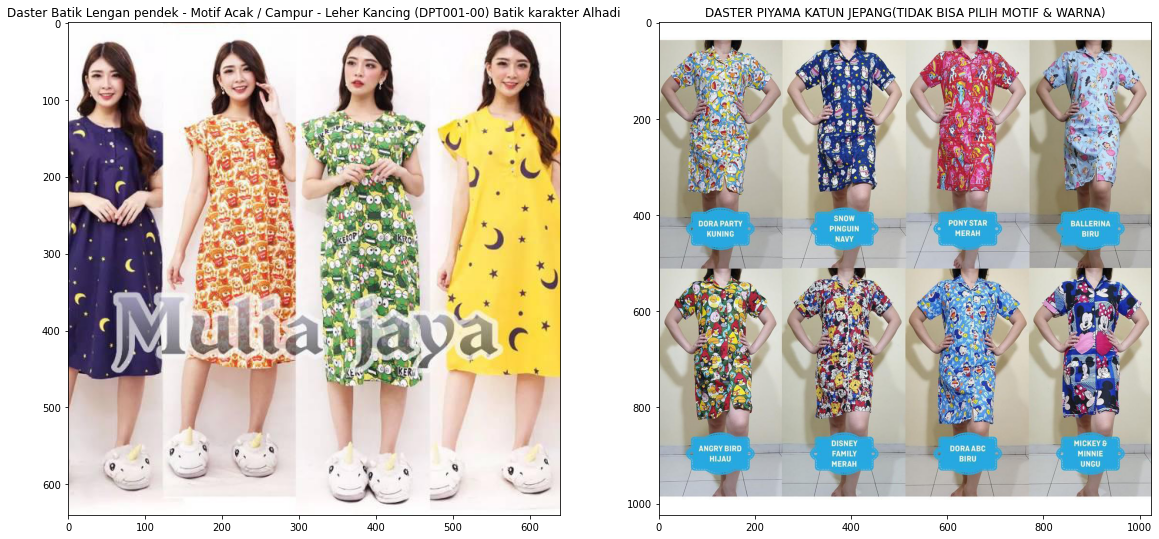

In [43]:
# Check matches of product train_2406599165 which has different F1 scores in each model
show_images(train, 'train_2406599165', matches=True)

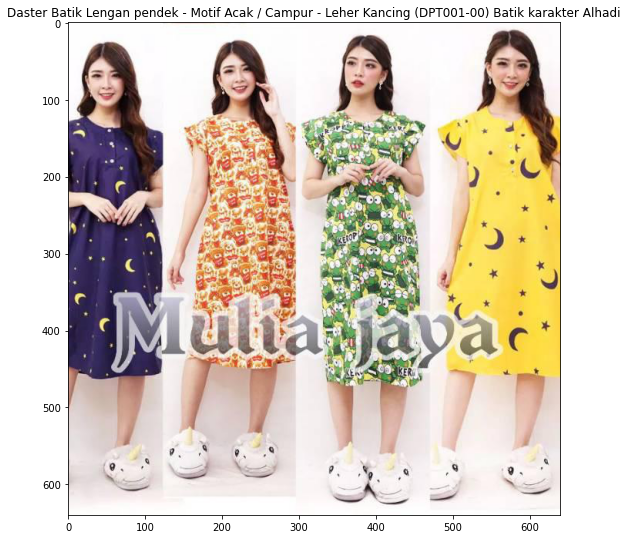

In [44]:
# Check matches of product train_2406599165 for model 6e which has F1 score of 0.666667
show_images(train, 'train_2406599165', model='6e', matches=False)

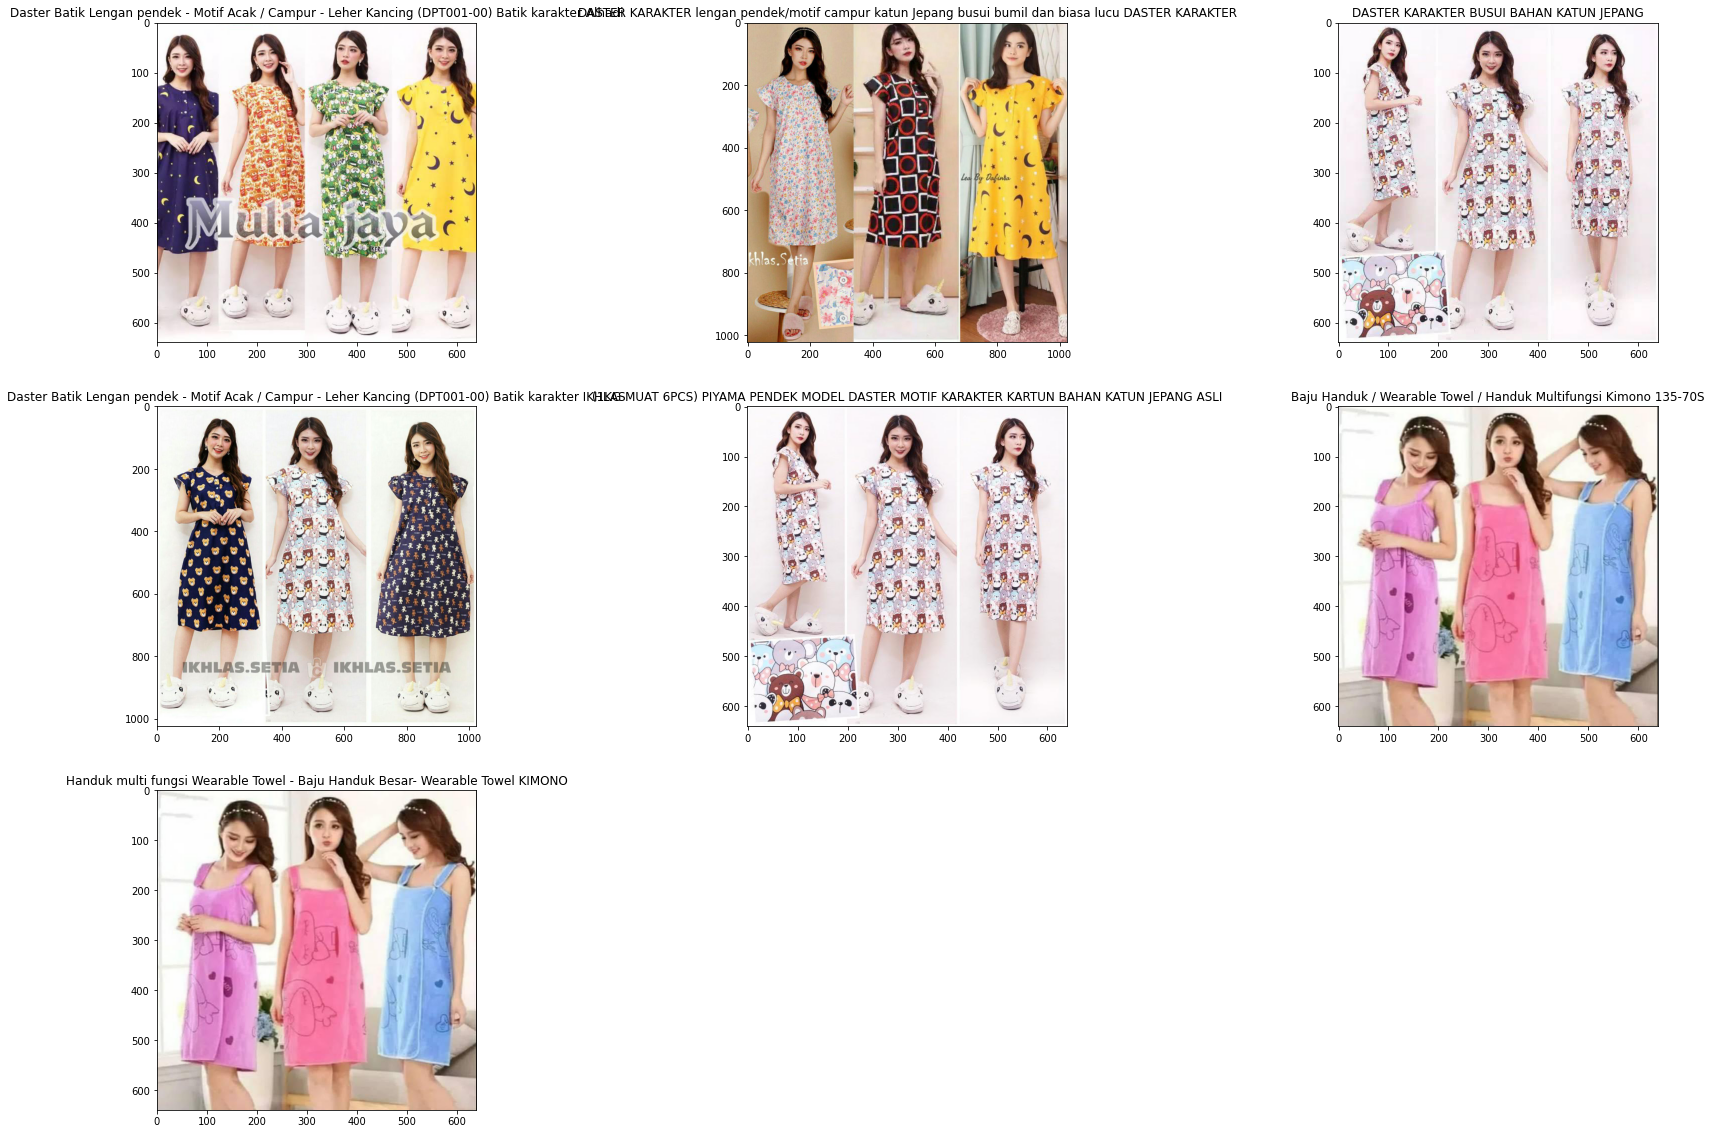

In [45]:
# Check matches of product train_2406599165 for model 6c which has F1 score of 0.222222
show_images(train, 'train_2406599165', model='6c', matches=False)

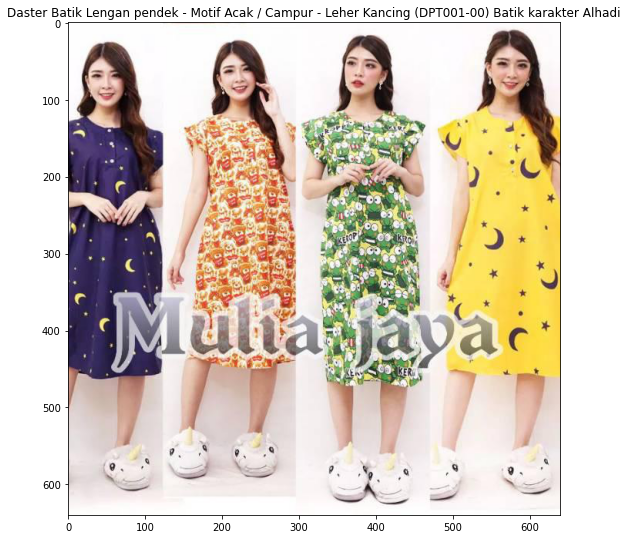

In [46]:
# Check matches of product train_2406599165 for model 8e which has F1 score of 0.666667
show_images(train, 'train_2406599165', model='8e', matches=False)

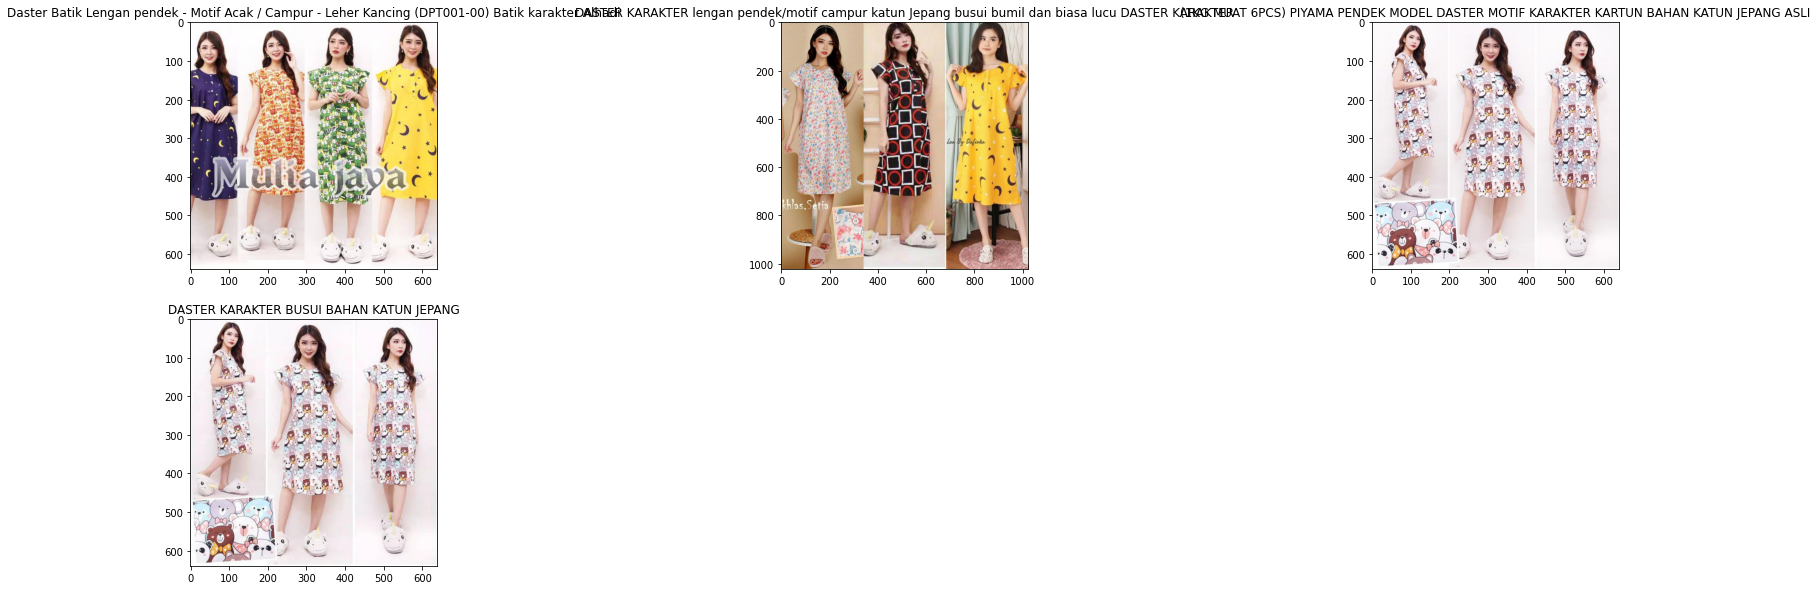

In [47]:
# Check matches of product train_2406599165 for model 8c which has F1 score of 0.333333
show_images(train, 'train_2406599165', model='8c', matches=False)

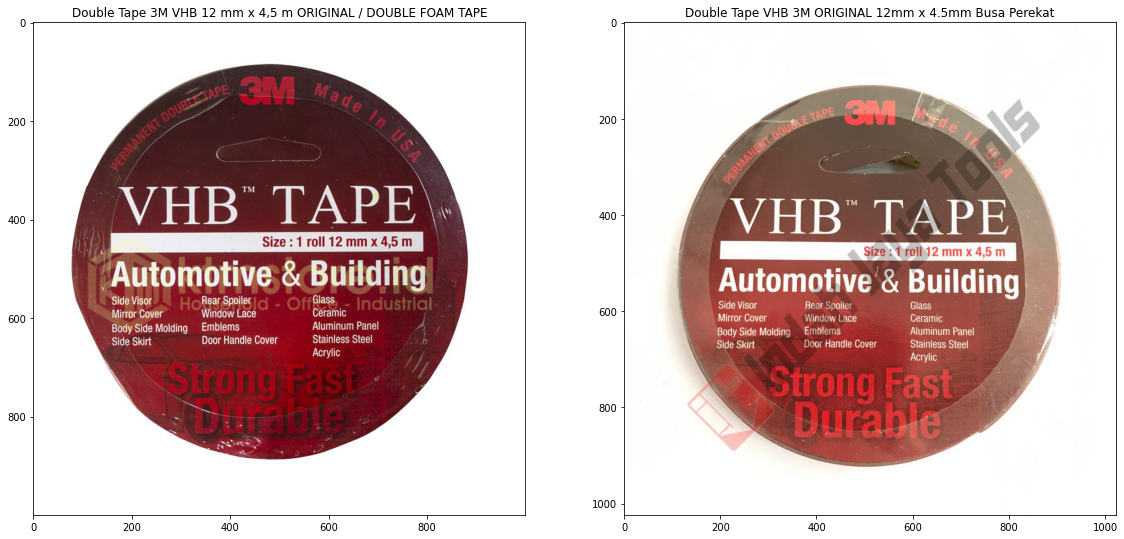

In [29]:
# Check matches of product train_3386243561 which has different F1 scores in each model
show_images(train, 'train_3386243561', matches=True)

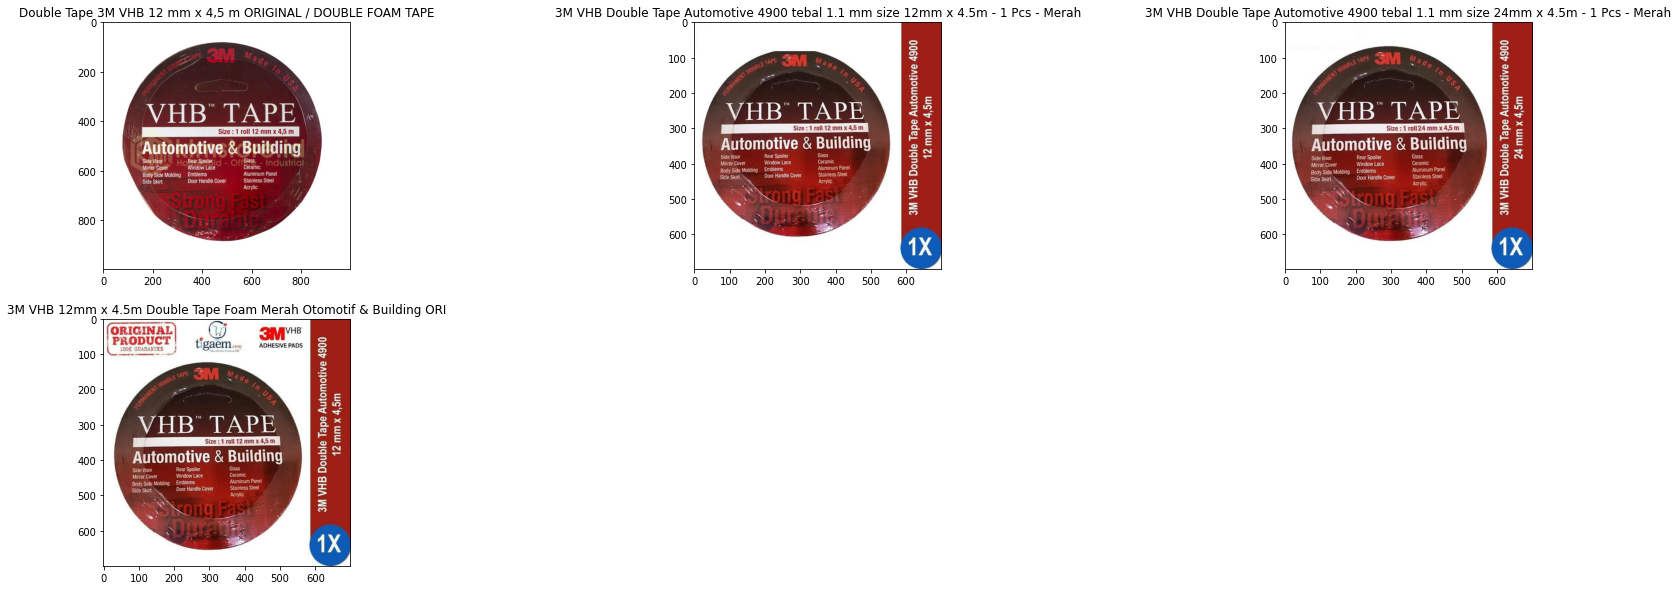

In [30]:
# Check predictions of product train_3386243561 for model 6e which has F1 score of 0.333333
show_images(train, 'train_3386243561', model='6e', matches=False)

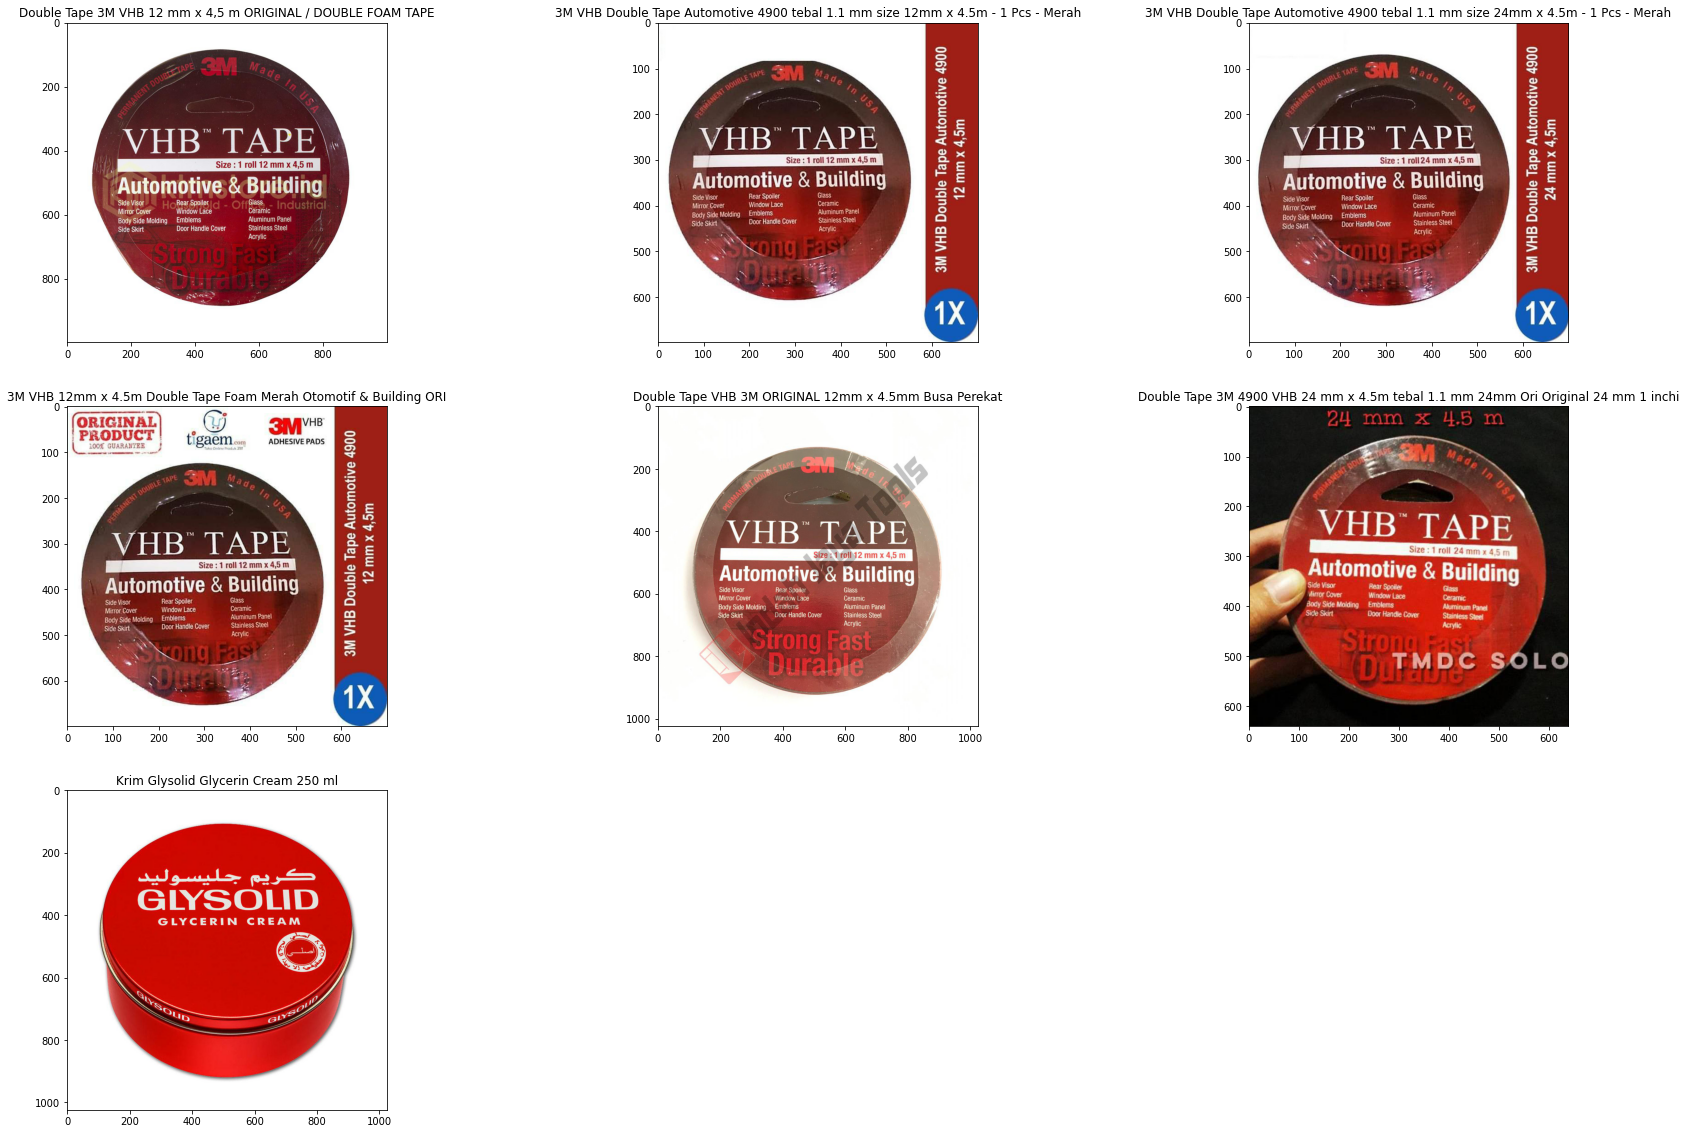

In [31]:
# Check predictions of product train_3386243561 for model 6c which has F1 score of 0.444444
show_images(train, 'train_3386243561', model='6c', matches=False)

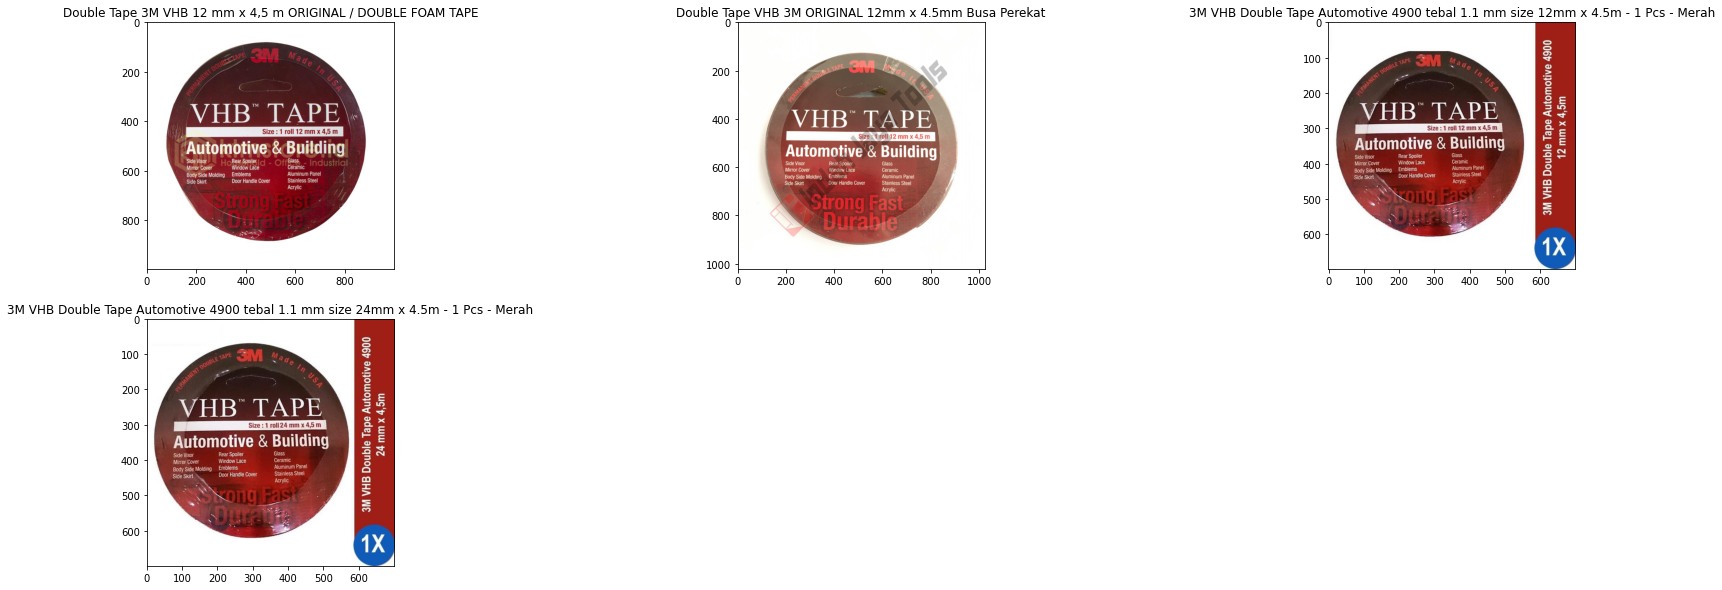

In [32]:
# Check predictions of product train_3386243561 for model 8e which has F1 score of 0.666667
show_images(train, 'train_3386243561', model='8e', matches=False)

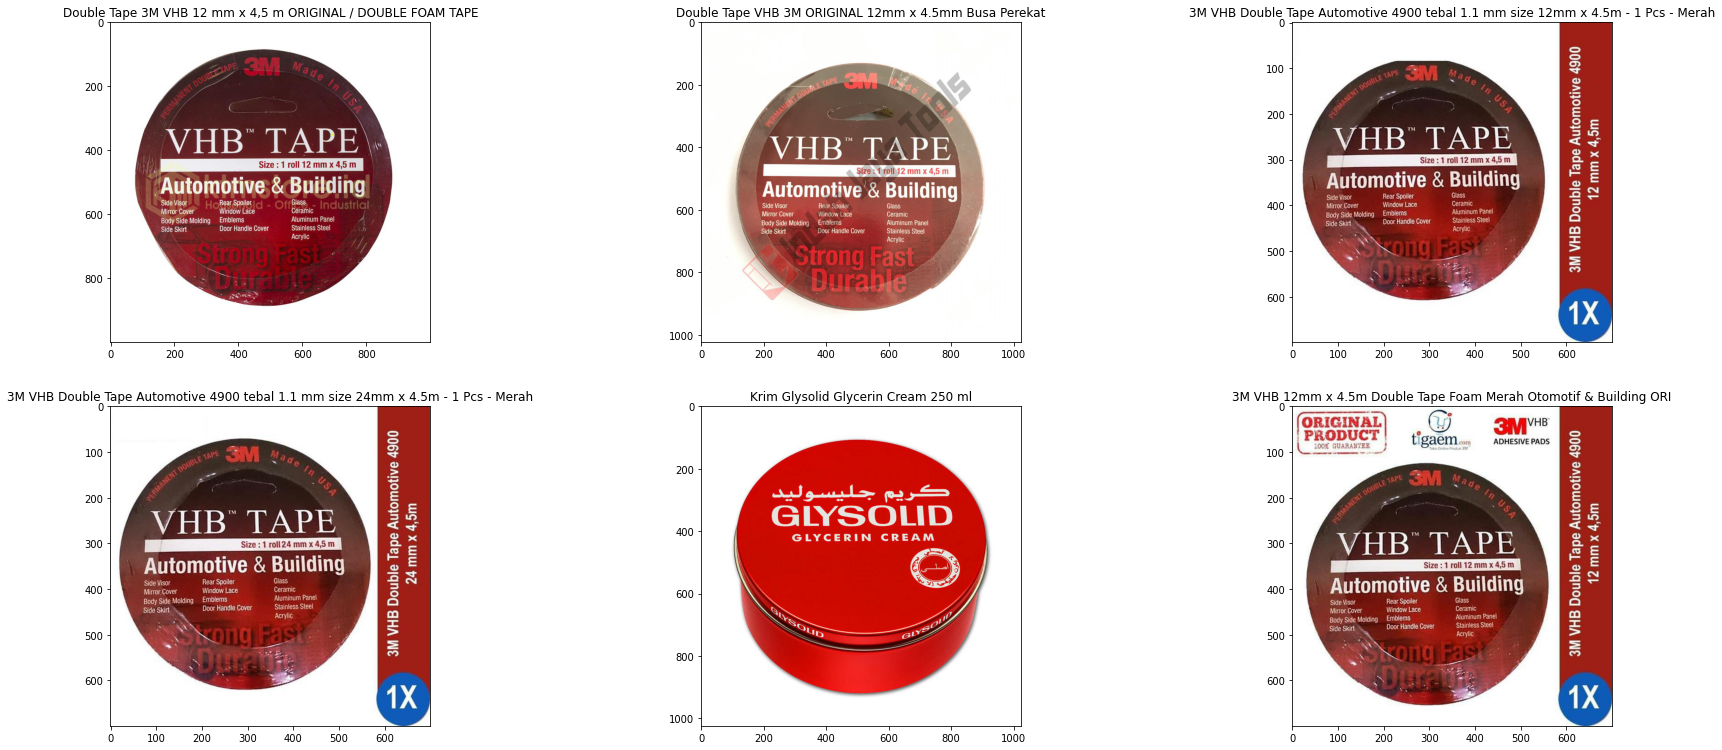

In [33]:
# Check predictions of product train_3386243561 for model 8c which has F1 score of 0.5
show_images(train, 'train_3386243561', model='8c', matches=False)

### Observations

**Product images**
- Similar images are not necessarily the same product (e.g. 3M tape)
- Products in the same group could have very different images (e.g. daster batik)

**Scores**
- The best image models are models 6 and 8, which had block7a, block7b and top_conv layers of EfficientNetB4 re-trained
- The most frequent F1 scores for image embedding models is 1.0 and 0.667
- Cosine distance scored higher than Euclidean distance in general
- Making a higher number of predictions generally results in lower scores